In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import sqlite3
import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime
import concurrent.futures
import matplotlib.pyplot as plt

#### Global Configuration

In [24]:
DATABASE_FILE_PATH = 'crypto_data.db'
COINS_TO_FETCH = ['BTC-USDT', 'ETH-USDT', 'SOL-USDT', 'ADA-USDT', 'XRP-USDT', 'DOGE-USDT']
REAL_COINS_SYMBOLS = [coin.replace('-USDT', 'USDT') for coin in COINS_TO_FETCH]
CUMULATIVE_PERFORMANCE_CSV = 'cumulative_performance_report.csv'
PERFORMANCE_SUMMARY_CSV = 'performance_summary_report.csv'

# PART 1: DATA PIPELINE

In [25]:
def fetch_and_update_database():
    """Fetches and stores raw historical data for all coins."""
    print("--- PART 1: FETCHING AND UPDATING RAW DATA ---")

    all_data_for_db = []
    def _fetch_single_coin_data(symbol):
        days_to_fetch = 4000
        start_timestamp = int(time.time()) - (days_to_fetch * 24 * 60 * 60)
        url = f"https://api.kucoin.com/api/v1/market/candles?type=1day&symbol={symbol}&startAt={start_timestamp}"
        print(f"Fetching data for {symbol}...")
        try:
            response = requests.get(url)
            response.raise_for_status()
            raw_data = response.json()['data']
            processed_data = []
            for row in raw_data:
                processed_data.append((
                    int(row[0]) * 1000,
                    datetime.fromtimestamp(int(row[0])).strftime('%Y-%m-%d'),
                    symbol.replace('-', ''),
                    float(row[1]), float(row[3]), float(row[4]), float(row[2]),
                    float(row[5]), float(row[6])
                ))
            return processed_data
        except requests.exceptions.RequestException as e:
            print(f"  > ERROR: Failed to fetch {symbol}. Reason: {e}")
            return []

    with concurrent.futures.ThreadPoolExecutor(max_workers=len(COINS_TO_FETCH)) as executor:
        future_to_coin = {executor.submit(_fetch_single_coin_data, coin): coin for coin in COINS_TO_FETCH}
        for future in concurrent.futures.as_completed(future_to_coin):
            all_data_for_db.extend(future.result())

    conn = sqlite3.connect(DATABASE_FILE_PATH)
    cur = conn.cursor()
    cur.execute("CREATE TABLE IF NOT EXISTS crypto_prices (id INTEGER PRIMARY KEY, Unix INTEGER, Date TEXT, Symbol TEXT, Open REAL, High REAL, Low REAL, Close REAL, Volume_Base REAL, Volume_Quote REAL, UNIQUE(Symbol, Unix))")
    cur.executemany("INSERT OR IGNORE INTO crypto_prices (Unix, Date, Symbol, Open, High, Low, Close, Volume_Base, Volume_Quote) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", all_data_for_db)
    conn.commit()
    print(f"\nDatabase is ready. Inserted {cur.rowcount} new records into 'crypto_prices'.")
    conn.close()

# PART 2: PORTFOLIO METRICS CALCULATION & STORAGE

In [26]:
def assign_weights(investment_goal, assets):
    weights = {}
    if investment_goal == 'risk_level':
        weights = {'BTCUSDT': 0.50, 'ETHUSDT': 0.25, 'SOLUSDT': 0.10, 'ADAUSDT': 0.05, 'XRPUSDT': 0.05, 'DOGEUSDT': 0.05}
    elif investment_goal == 'market_cap':
        weights = {'BTCUSDT': 0.50, 'ETHUSDT': 0.3333, 'SOLUSDT': 0.0556, 'ADAUSDT': 0.0444, 'XRPUSDT': 0.0444, 'DOGEUSDT': 0.0222}
    elif investment_goal == 'safety':
        weights = {'BTCUSDT': 0.50, 'ETHUSDT': 0.3333, 'SOLUSDT': 0.0833, 'ADAUSDT': 0.05, 'XRPUSDT': 0.0333, 'DOGEUSDT': 0.00}
    elif investment_goal == 'growth':
        weights = {'BTCUSDT': 0.20, 'ETHUSDT': 0.40, 'SOLUSDT': 0.20, 'ADAUSDT': 0.10, 'XRPUSDT': 0.05, 'DOGEUSDT': 0.05}
    elif investment_goal == 'equal':
        equal_weight = 1 / len(assets)
        for asset in assets: weights[asset] = round(equal_weight, 4)
    total_weight = sum(weights.values())
    if not np.isclose(total_weight, 1.0):
        factor = 1.0 / total_weight
        weights = {asset: weight * factor for asset, weight in weights.items()}
    return weights

In [27]:
def calculate_portfolio_return(weights, daily_returns_df):
    filtered_weights = {k: v for k, v in weights.items() if k in daily_returns_df.columns}
    weights_series = pd.Series(filtered_weights).reindex(daily_returns_df.columns, fill_value=0)
    return daily_returns_df.mul(weights_series, axis='columns').sum(axis=1)

In [28]:
def calculate_portfolio_volatility(portfolio_daily_returns):
    return round(np.std(portfolio_daily_returns), 2)

In [29]:
def calculate_and_store_portfolio_metrics():
    print("\n--- PART 2: CALCULATING AND STORING PORTFOLIO METRICS ---")
    conn = sqlite3.connect(DATABASE_FILE_PATH)
    cur = conn.cursor()
    cur.execute("PRAGMA foreign_keys = ON;")
    cur.execute("CREATE TABLE IF NOT EXISTS portfolio (id INTEGER PRIMARY KEY, name TEXT UNIQUE, created_at TEXT, expected_return REAL, expected_risk REAL)")
    cur.execute("CREATE TABLE IF NOT EXISTS portfolio_assets (id INTEGER PRIMARY KEY, portfolio_id INTEGER, asset_name TEXT, weight REAL, FOREIGN KEY (portfolio_id) REFERENCES portfolio(id))")

    query = "SELECT Date, Symbol, Close FROM crypto_prices ORDER BY Date ASC"
    df = pd.read_sql_query(query, conn, parse_dates=['Date'])
    prices_df = df.pivot(index='Date', columns='Symbol', values='Close')
    daily_returns_df = prices_df.pct_change() * 100

    rules_to_test = ['risk_level', 'market_cap', 'safety', 'growth', 'equal']
    for rule in rules_to_test:
        weights = assign_weights(rule, REAL_COINS_SYMBOLS)
        portfolio_returns = calculate_portfolio_return(weights, daily_returns_df).dropna()
        expected_return = round(portfolio_returns.mean(), 4)
        expected_risk = calculate_portfolio_volatility(portfolio_returns)
        created_at = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        cur.execute("INSERT INTO portfolio (name, created_at, expected_return, expected_risk) VALUES (?, ?, ?, ?) ON CONFLICT(name) DO UPDATE SET created_at=excluded.created_at, expected_return=excluded.expected_return, expected_risk=excluded.expected_risk;", (rule, created_at, expected_return, expected_risk))
        portfolio_id = cur.execute("SELECT id FROM portfolio WHERE name = ?", (rule,)).fetchone()[0]
        cur.execute("DELETE FROM portfolio_assets WHERE portfolio_id = ?", (portfolio_id,))
        assets_to_insert = [(portfolio_id, asset, weight) for asset, weight in weights.items() if weight > 0]
        cur.executemany("INSERT INTO portfolio_assets (portfolio_id, asset_name, weight) VALUES (?, ?, ?)", assets_to_insert)

    conn.commit()
    print("Successfully stored summary metrics and weights in the database.")
    conn.close()

# PART 3: FINAL REPORTING & VISUALIZATION

In [38]:
def generate_final_report():

    print("\n--- PART 3: GENERATING FINAL COMPREHENSIVE REPORT ---")
    conn = sqlite3.connect(DATABASE_FILE_PATH)

    PORTFOLIO_RULE_TO_COMPARE = 'risk_level'
    FINAL_COMPARISON_CSV = 'final_portfolio_vs_all_coins_comparison.csv'

    print("Loading all historical data for comprehensive analysis...")
    query = "SELECT Date, Symbol, Close FROM crypto_prices ORDER BY Date ASC"
    df = pd.read_sql_query(query, conn, parse_dates=['Date'])
    prices_df = df.pivot(index='Date', columns='Symbol', values='Close')
    daily_returns_df = prices_df.pct_change() * 100

    comparison_df = daily_returns_df[REAL_COINS_SYMBOLS].copy()

    portfolio_weights = assign_weights(PORTFOLIO_RULE_TO_COMPARE, REAL_COINS_SYMBOLS)
    comparison_df[PORTFOLIO_RULE_TO_COMPARE] = calculate_portfolio_return(portfolio_weights, daily_returns_df)

    comparison_df.dropna(inplace=True)

    initial_investment = 100
    cumulative_growth_df = pd.DataFrame(index=comparison_df.index)
    for col in comparison_df.columns:
        cumulative_growth_df[col] = initial_investment * (1 + comparison_df[col] / 100).cumprod()

    print("\nGenerating final comparison plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))

    plt.plot(cumulative_growth_df.index, cumulative_growth_df[PORTFOLIO_RULE_TO_COMPARE],
             label=f"Portfolio: {PORTFOLIO_RULE_TO_COMPARE.title()}", color='blue', linewidth=3, zorder=10)

    for coin in REAL_COINS_SYMBOLS:
        plt.plot(cumulative_growth_df.index, cumulative_growth_df[coin],
                 label=f"Single Asset: {coin}", alpha=0.6, linewidth=1)

    plt.title(f'Growth of $100: "{PORTFOLIO_RULE_TO_COMPARE.title()}" Portfolio vs. All Individual Coins', fontsize=16)
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.yscale('log')
    plt.show()

    print("\n" + "="*80)
    print("FINAL CONCLUSION: Performance vs. Risk (Volatility)")
    print("="*80)

    summary = []
    def calculate_volatility(daily_returns_series):
        return round(daily_returns_series.std(), 2)

    for col in comparison_df.columns:
        final_value = cumulative_growth_df[col].iloc[-1]
        volatility = calculate_volatility(comparison_df[col])
        summary.append({'Strategy': col, 'Final Value of $100': f"${final_value:,.2f}", 'Volatility (Risk) %': volatility})

    summary_df = pd.DataFrame(summary).set_index('Strategy')
    print(summary_df)

    print("\n--- Key Insights ---")
    print(f"1. Performance: The chart visually shows how the '{PORTFOLIO_RULE_TO_COMPARE}' portfolio (blue line) performed relative to holding each of the six coins individually.")
    print("2. Risk (Volatility): The portfolio's growth curve is generally smoother than the most volatile individual assets (like SOLUSDT or DOGEUSDT), indicating that diversification successfully reduced daily price swings. This is confirmed by its lower volatility in the table above.")
    print("3. Conclusion: Diversification creates a 'middle path'. The portfolio likely did not capture the absolute highest gains (from the single best-performing coin) but it also protected the investment from the worst losses (from the single worst-performing coin). It offers a more balanced risk-return profile, which is the primary goal of creating a portfolio.")

    export_df = cumulative_growth_df.reset_index()
    export_df.rename(columns={'index': 'Date'}, inplace=True)
    export_df.to_csv(FINAL_COMPARISON_CSV, index=False)
    print("\n" + "="*80)
    print(f"✅ Full comparison data exported to '{FINAL_COMPARISON_CSV}'")

    conn.close()

--- PART 1: FETCHING AND UPDATING RAW DATA ---
Fetching data for BTC-USDT...
Fetching data for ETH-USDT...
Fetching data for SOL-USDT...
Fetching data for ADA-USDT...
Fetching data for XRP-USDT...
Fetching data for DOGE-USDT...

Database is ready. Inserted 0 new records into 'crypto_prices'.

--- PART 2: CALCULATING AND STORING PORTFOLIO METRICS ---
Successfully stored summary metrics and weights in the database.

--- PART 3: GENERATING FINAL COMPREHENSIVE REPORT ---
Loading all historical data for comprehensive analysis...

Generating final comparison plot...


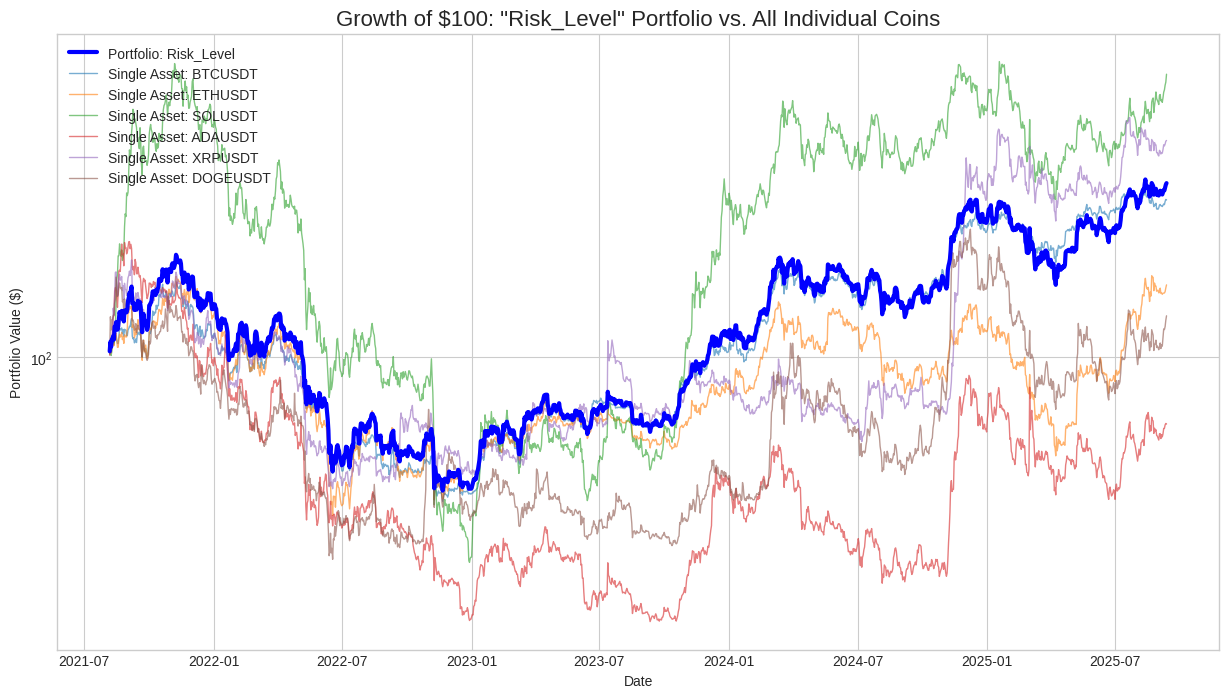


FINAL CONCLUSION: Performance vs. Risk (Volatility)
           Final Value of $100  Volatility (Risk) %
Strategy                                           
BTCUSDT                $281.72                 2.82
ETHUSDT                $160.86                 3.74
SOLUSDT                $645.14                 5.34
ADAUSDT                 $64.28                 4.83
XRPUSDT                $416.78                 4.69
DOGEUSDT               $131.18                 5.01
risk_level             $314.61                 3.19

--- Key Insights ---
1. Performance: The chart visually shows how the 'risk_level' portfolio (blue line) performed relative to holding each of the six coins individually.
2. Risk (Volatility): The portfolio's growth curve is generally smoother than the most volatile individual assets (like SOLUSDT or DOGEUSDT), indicating that diversification successfully reduced daily price swings. This is confirmed by its lower volatility in the table above.
3. Conclusion: Diversification

In [39]:
if __name__ == "__main__":
    fetch_and_update_database()
    calculate_and_store_portfolio_metrics()
    generate_final_report()
    print("\n--- FULL PIPELINE COMPLETE ---")